<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#background" data-toc-modified-id="background-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>background</a></span></li><li><span><a href="#procedure" data-toc-modified-id="procedure-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>procedure</a></span><ul class="toc-item"><li><span><a href="#outline" data-toc-modified-id="outline-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>outline</a></span></li><li><span><a href="#batch" data-toc-modified-id="batch-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>batch</a></span></li></ul></li><li><span><a href="#docs" data-toc-modified-id="docs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>docs</a></span></li><li><span><a href="#demo" data-toc-modified-id="demo-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>demo</a></span></li></ul></div>

# cygnss-data-pub-l3sm

*To review the structure/metadata in the revised netCDFs, I recommend the header dumps (.cdl) stored as text files in [level3/](level3/).*

## background

This [README.md](README.md) and the Python script ([podaac_cygnss_sm_adapter.py](podaac_cygnss_sm_adapter.py)) document+implement the procedure to generate revised netCDF files for CYGNSS L3 Soil Moisture Data Product for  public release ASAP (September 2020).

**Manuscript**

>Chew, C.; Small, E. Description of the UCAR/CU Soil Moisture Product. Remote Sens. 2020, 12, 1558. https://doi.org/10.3390/rs12101558

**Dataset**

The current handbook is copied into this repository at [ucar_cu_sm_handbook.pdf](ucar_cu_sm_handbook.pdf) (2020-09-23).

The production netCDF files are hosted by UCAR/COSMIC: https://data.cosmic.ucar.edu/gnss-r/soilMoisture/

**Why revise the files? Why this way? *Why?***

An inconvenient "gotcha" in netCDF is variable initialization -- we have to set the `_FillValue` and `datatype` for a variable when its initialized.

The netCDF4 library is allocating space for the data array and prefilling it with the prescribed value whenever a user specifies a `_FillValue` for a new netCDF variable. It makes sense. It'd be awfully inefficient for netCDF to try to do all the dynamic memory management by itself. Every byte after the resized variable would need to be indexed again. Not feasible for large datasets. 

So that's the gist of why we felt it was necessary to write a dedicated script to modify these SM outputs that are already in great shape, for the most part. Some of our fixes have potential to be destructive, like updating the `_FillValue`s to something other than `NaN` as mentioned already.

## procedure

*Jump to the bottom of this section for the batch procedure.*

### outline

The source files (which are in pretty good shape to begin with, I should say) are located on a file server hosted by UCAR/COSMIC:

>https://data.cosmic.ucar.edu/gnss-r/soilMoisture/

The current handbook is copied into this repository at [ucar_cu_sm_handbook.pdf](ucar_cu_sm_handbook.pdf) (2020-09-23).

**Grab the latest copies of the netCDF files from UCAR/COSMIC using `wget`:**

```shell
wget -r -np -nH --cut-dirs=3 -R index.html https://data.cosmic.ucar.edu/gnss-r/soilMoisture/
```

Run that same command again and `wget` will attempt some rudimentary checks to reconcile the local copy of original netCDFs with available files in the UCAR/COSMIC directory.

**Decompress ALL downloaded gzipped netCDF files using the `find` and `tar` unix utilities:**

```shell
find level3/ -type f -name "*.gz" -exec gunzip {} \;
```

**Modify the dataset to a new netCDF4 file with adapter script `podaac_cygnss_sm_adapter.py`.**

The modifier script `podaac_cygnss_sm_adapter.py` is written for Python 3. The only dependency is Python package `netCDF4`, maintained by Unidata. I prefer to install it in a conda environment from the `conda-forge` channel. (It has the most stable sources for geospatial tools I use alot; mostly GDAL dependencies GEOS and PROJ). You can try installing like this:

```shell
conda install -c conda-forge netCDF4
```

The script takes exactly one input argument, the path to a netCDF file structured like the production netCDF outputs produced by the CYGNSS investigators.

**Here's an example that generated a revised copy of the first file in the series:**

```shell
./podaac_cygnss_sm_adapter.py level3/2017/077/ucar_cu_cygnss_sm_v1_2017_077.nc
```

The new netCDF should be written to the same directory as the original, but with an underscore prefixing the original filename.

**This command gives the header returned by `ncdump -h` for the revised file from the command above:**

```shell
ncdump -h level3/2017/077/_ucar_cu_cygnss_sm_v1_2017_077.nc > docs/example_output_2017_077.cdl
```

**Gen new netCDFs in a batch by applying script to the results of unix `find`:**

```shell
find level3/ -type f -name "ucar_cu_cygnss_sm_v*.nc" -exec ./podaac_cygnss_sm_adapter.py {} \;
```

*Note that the `find` command is ignoring files that don't fit the wildcard pattern that excludes any revised netCDF files that already exist in the `level3/` directory (because they all begin with `_`).*

You may find it convenient to execute the script in other modes invoked from the shell. 

For instance, **generate outputs for only one year's files:**

```shell
find level3/2019/ -type f -name "ucar_cu_cygnss_sm_v*.nc" -exec ./podaac_cygnss_sm_adapter.py {} \;
```

*NOTE: I needed to handle some exceptions and re-process 2019 files due to date string representation that isn't consistent with the same string in the files for other years.*

If you make any modifications, should probably capture the stdout that's returned by the Python script with each successive execution in case a bug is introduced. Python sends exception messages and warnings to stdout, so you can just pipe all everything to a log file like this:

```shell
# Get a datetime stamp for the log filename using the unix `date` util:
TIMESTAMP = $(date +"%Y%m%dT%H%M%SZ")
# Call find like before and pipe output to the log file.
find level3/ -type f -name "ucar_cu_cygnss_sm_v*.nc" -exec ./podaac_cygnss_sm_adapter.py {} \; > "docs/${TIMESTAMP}.log"
```

Check the generic format for the revised netCDFs in the `ncdump` output [here](docs/example_output_2017_077.cdl).

**Dump headers with CDL extensions for ALL of the revised data files** to (hopefully) make reviewing them a bit less tedious for Clara and Eric. Again, using the unix `find` command:

```shell
find level3/ -type f -name "_ucar_cu_cygnss_sm_v*.nc" -exec bash -c 'ncdump -h "${0}" > "${0/.nc/.cdl}"' {} \;
```

The files all have `.cdl` extension, and they're located adjacent to the original and revised files for which they document PODAAC's changes, for instance: [*level3/2017/077/_ucar_cu_cygnss_sm_v1_2017_077.cdl*](level3/2017/077/_ucar_cu_cygnss_sm_v1_2017_077.cdl)

### batch

To execute the entire process described below, generating a new batch of nc files, execute the bash script [`batch.sh`](batch.sh) and wait a few minutes:

```shell
[cygnss-data-pub-l3sm:master] $ ./batch.sh 
# [1/4] Grab the latest copies of the netCDF files from UCAR/COSMIC using 'wget'. 
# [2/4] Decompress ALL downloaded gzipped netCDF files using the 'find' and 'tar' unix utils. 
# [3/4] Find + loop source netCDFs, generate revised copies and pipe stdout to a 'docs/*.log'.
# [4/4] Dump CDL headers for Clara's and Eric's reference. 
```

## docs

handbook: [docs/ucar_cu_sm_handbook.pdf](docs/ucar_cu_sm_handbook.pdf)

>"The value of the peak cross-correlation of each DDM (called `Pr,eff` in this document) is related to surface characteristics at the specular reflection point of the GNSS signal— including the roughness of the surface and the surface dielectric constant." (Section 1.5 CYGNSS Observables, *CYGNSS Soil Moisture Product User Handbook*)


## demo

The major change that I made was to add a `time` dimension (size=1) and add it to the daily soil moisture variables. **This change facilitates aggregation by certain software that read netCDF4.** 

See the example below.

In [1]:
from glob import glob
from xarray import open_mfdataset
from warnings import filterwarnings
import matplotlib.pyplot as plt
filterwarnings('ignore')

# Get the paths to all of the revised files for the year 2018:
example_d = "../level3/2018/*/_ucar_cu_cygnss_sm_v1_2018_*.nc"
example_f = sorted(glob(example_d))

# There should be 365 nc files. Print the first five:
len(example_f), example_f[:5]

(365,
 ['../level3/2018/001/_ucar_cu_cygnss_sm_v1_2018_001.nc',
  '../level3/2018/002/_ucar_cu_cygnss_sm_v1_2018_002.nc',
  '../level3/2018/003/_ucar_cu_cygnss_sm_v1_2018_003.nc',
  '../level3/2018/004/_ucar_cu_cygnss_sm_v1_2018_004.nc',
  '../level3/2018/005/_ucar_cu_cygnss_sm_v1_2018_005.nc'])

In [2]:
xds = open_mfdataset(example_f, combine="by_coords", concat_dim="time", parallel=True)
print(xds)

<xarray.Dataset>
Dimensions:         (lat: 252, lon: 802, startstop: 2, time: 365, timeslices: 4)
Coordinates:
  * time            (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
Dimensions without coordinates: lat, lon, startstop, timeslices
Data variables:
    latitude        (time, lon, lat) float32 dask.array<chunksize=(1, 802, 252), meta=np.ndarray>
    longitude       (time, lon, lat) float32 dask.array<chunksize=(1, 802, 252), meta=np.ndarray>
    timeintervals   (time, startstop, timeslices) timedelta64[ns] dask.array<chunksize=(1, 2, 4), meta=np.ndarray>
    SIGMA_daily     (time, lon, lat) float32 dask.array<chunksize=(1, 802, 252), meta=np.ndarray>
    SM_daily        (time, lon, lat) float32 dask.array<chunksize=(1, 802, 252), meta=np.ndarray>
    SM_subdaily     (time, timeslices, lon, lat) float32 dask.array<chunksize=(1, 4, 802, 252), meta=np.ndarray>
    SIGMA_subdaily  (time, timeslices, lon, lat) float32 dask.array<chunksize=(1, 4, 802, 252), meta=np.ndarra

**Group daily soil moisture by month and average (ignore nans):**

In [5]:
soil_moisture_mon_mean = xds.groupby("time.month").mean("time")
print(soil_moisture_mon_mean)

<xarray.Dataset>
Dimensions:         (lat: 252, lon: 802, month: 12, startstop: 2, timeslices: 4)
Coordinates:
  * month           (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: lat, lon, startstop, timeslices
Data variables:
    latitude        (month, lon, lat) float32 dask.array<chunksize=(1, 802, 252), meta=np.ndarray>
    longitude       (month, lon, lat) float32 dask.array<chunksize=(1, 802, 252), meta=np.ndarray>
    timeintervals   (month, startstop, timeslices) timedelta64[ns] dask.array<chunksize=(1, 2, 4), meta=np.ndarray>
    SIGMA_daily     (month, lon, lat) float32 dask.array<chunksize=(1, 802, 252), meta=np.ndarray>
    SM_daily        (month, lon, lat) float32 dask.array<chunksize=(1, 802, 252), meta=np.ndarray>
    SM_subdaily     (month, timeslices, lon, lat) float32 dask.array<chunksize=(1, 4, 802, 252), meta=np.ndarray>
    SIGMA_subdaily  (month, timeslices, lon, lat) float32 dask.array<chunksize=(1, 4, 802, 252), meta=np.ndarray>


**Calculate monthly means of `SM_daily` and draw an quick, dirty plot:**

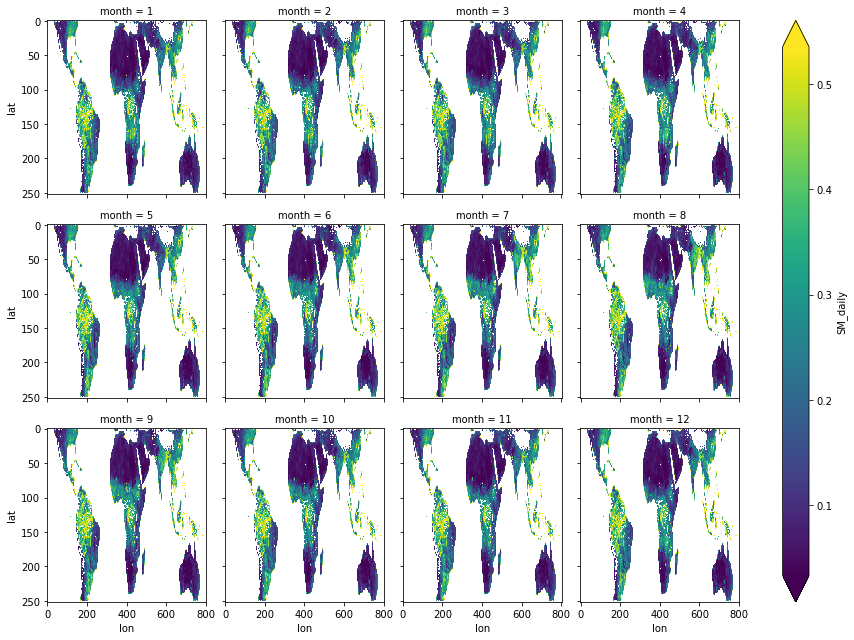

In [4]:
soil_moisture_mon_mean['SM_daily'].plot.imshow("lon", "lat", col="month", col_wrap=4, robust=True)
plt.gca().invert_yaxis()